# Automatic arrangement of plots

There are many visualization plotting libraries out there in the Python ecosystem, but not many give the fine-grain control of Matplotlib whilst still being rather intuitive.

## Aim:

    'To provide a function which provides grid-like layout for matplotlib plots without thinking about it, just by specifying the number of plots we want.'

## Solution:

We provide a very flexible and powerful function called `gridplot`, which given a size $n$ for the number of plots, and some optional information about which dimension you wish to stretch, will generate a grid of equally-sized plots along that given dimension.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0,"../")
# our main import
import turbopanda as turb

print("turbopanda version: %s" % turb.__version__)

turbopanda version: 0.2.4


## Just one plot...

This returns the *figure* and a *list of Axes* objects, as you would if you made a call to `plt.subplots()`.

(<Figure size 144x144 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x1db6736df08>])

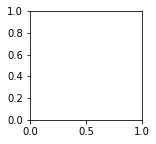

In [5]:
turb.plot.gridplot(1)

## More than one plot:

The array of axes returned will **always** be one-dimensional and flattened, so if you wish to access a particular one you will have to manually calculate this; but from my experience this is rarely an issue.

(<Figure size 432x144 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DB61444788>,
       dtype=object))

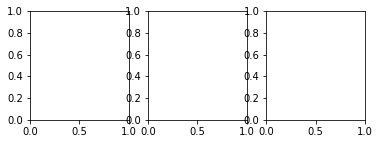

In [6]:
turb.plot.gridplot(3)

## Plots orient by finding the closest shared *factor*

In this case, by choosing 6 - the factors closest together are 2 and 3, which will be oriented as close to a *square* shape as possible.

(<Figure size 432x288 with 6 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1db67c68548>])

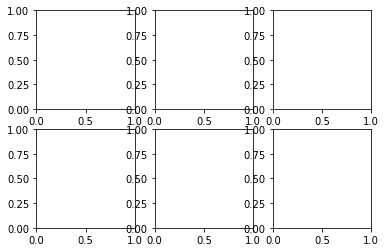

In [7]:
turb.plot.gridplot(6)

## Default orientation is a *square-like* grid: but this is optional.

For factors that have an integer square-root, this will always form a grid, but we can choose to oriente by *row* or by *column*.

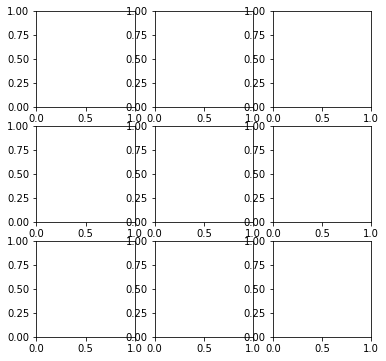

In [11]:
fig, axes = turb.plot.gridplot(9)

### Instead by *column*...

We see that `gridplot` has actually returned a $5\times 2$ grid, but the last Axes is actually hidden from view. This is because this is the best format for giving a *stretched* column-wise grid, and $5\times 2$ factors provides this much better than $3 \times 3$.

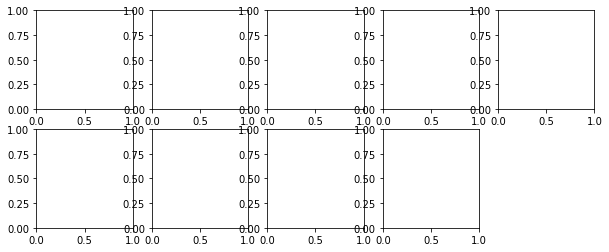

In [13]:
fig, axes = turb.plot.gridplot(9, arrange='column')

The reverse is true when specifying rows:

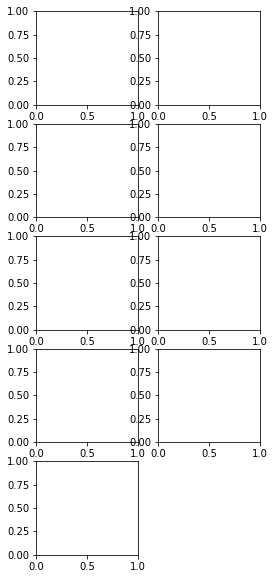

In [14]:
fig, axes = turb.plot.gridplot(9, arrange='row')

## How this works under the hood: *factorization*.

The root of this method using using a `factor` function which, given $n$, returns a list of all the known factors of that number, including $1$ and $n$.

In [18]:
turb.utils._factor._factor(10)

[1, 2, 5, 10]

Now, using this list of factors, we sort them by size and, for a *square-like* grid, we want to choose two factors that are as close to each other as possible. One of the easiest ways to do this is to choose the *median* value within a sorted array of factors. The other factor therefore is the *integer division* of the first factor.

In [25]:
x = np.sort(np.asarray(turb.utils._factor._factor(10)))
x[x.shape[0] // 2], (x[-1] // x[x.shape[0] // 2])

(5, 2)

For a *diagonal-like* direction, we choose the quarter index as a starting guide:

In [26]:
x[x.shape[0] // 4], (x[-1] // x[x.shape[0] // 4])

(2, 5)

You may notice that, for higher numbers, the chances of having a factor which neatly forms a square or row/column axis can be challenging. So we introduced the `nearest_factors` function *found in `.utils`*, particularly for plot numbers that are **prime numbers** or generally have few factors.

Let's take the example of the prime number $19$:

In [41]:
turb.utils._factor._factor(19), turb.utils._factor._square_factors(19), turb.utils._factor._diag_factors(19)

([1, 19], (19, 1), (1, 19))

Not a very promising prospect of a good grid! But what about if we *lie* and pretend that the user inputted $n=20$?

In [40]:
turb.utils._factor._square_factors(20)

(5, 4)

A $5\times 4$ grid is *pretty square-like*, and I'd consider this a success for simplicities sake. Introducing `nearest_factors`:

In [42]:
turb.utils.nearest_factors(19)

(5, 4)

### `nearest_factors`: Searching around the input space

This function has a bunch of extra optional parameters that involve *how much searching* around the input space you want if the initial value is bad. 

Note that **only higher values of $n$** are acceptable, given that the user expects **at least $n$ plots** available to them to draw.

Thus for the 19 case we use the normal method:

In [50]:
turb.utils._factor._square_factors(19)

(19, 1)

In [49]:
from scipy import stats

Whereby we introduce the cutoff variable $\epsilon=6$, by default, and if the **difference** $(a-b) > \epsilon$, we perform a search, where $a$ and $b$ are the chosen factors, respectively. By default, the search range $r=5$.

For each searched $n_i$, we determine $v_i = \{a_i, b_i\}$, and thus we calculate the weighted distance as:

$$
d = \left(1-f(x) \right)||a - b||_2
$$

whereby the weighting $(1-f(x))$ is the inverse of the probability density function of a Gaussian distribution $f(x)$:

$$
f(x)=\frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x-n}{\sigma} \right)^2}
$$

where $x \in \{n,n+1,\dots,n+r\}$ is the search space, $\sigma$ is a parameter to the function to specify the variance of the weighting.

### Distancing for $n=19$:

In [67]:
d_19 = np.linalg.norm(np.asarray(turb.utils._factor._square_factors(19)),2)
print(d_19)

19.026297590440446


### Distancing for $n=20$:

In [65]:
d_20 = np.linalg.norm(np.asarray(turb.utils._factor._square_factors(20)),2)
print(d_20)

6.4031242374328485


### Scaling $n=20$ by an inverse gaussian:

The weighting factor is designed to punish selections of $n$ that are simply too far away from the original chosen $n$ selected.

In [55]:
from scipy import stats

In [68]:
w = np.asarray(1-stats.norm.pdf(np.arange(19, 21, 1), 19, 1.5))
print(w)

[0.73403848 0.78703466]


In [72]:
d_19*w[0], d_20*w[1]

(13.966034558222717, 5.0394807262596775)

From this, we obviously choose $n$ that minimizes $d_i$:

$$
n_j = \arg \min_i d
$$

All that remains then, is to clean and hide figures that are additional extras for the shape of the plot.

## Examples



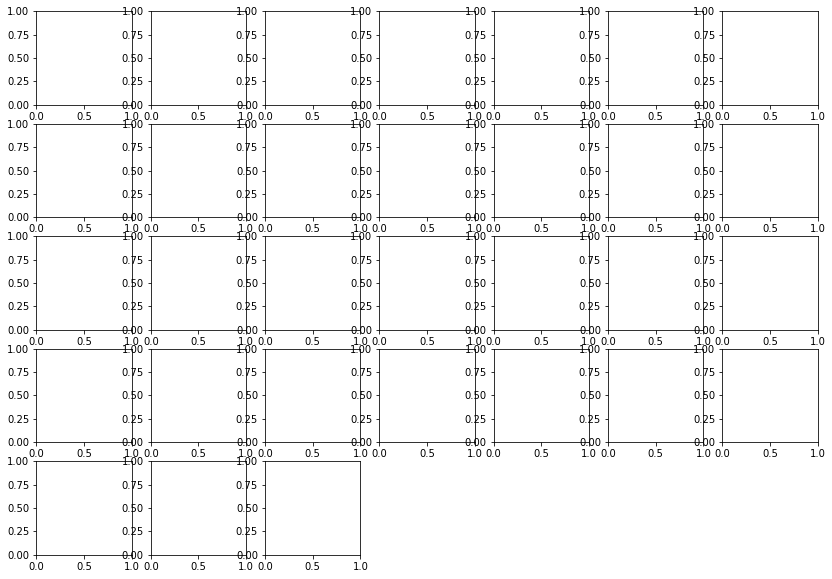

In [76]:
fig, axes = turb.plot.gridplot(31, arrange='column')